# Lifetime vs. particle index plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound

In [2]:
path = '/Users/mariahjones/Desktop/research/projects/orbitals/final_data/'

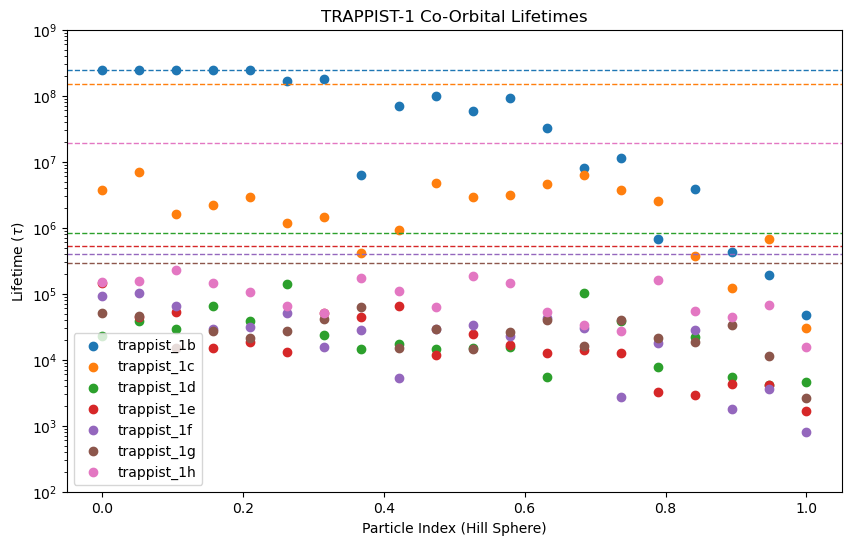

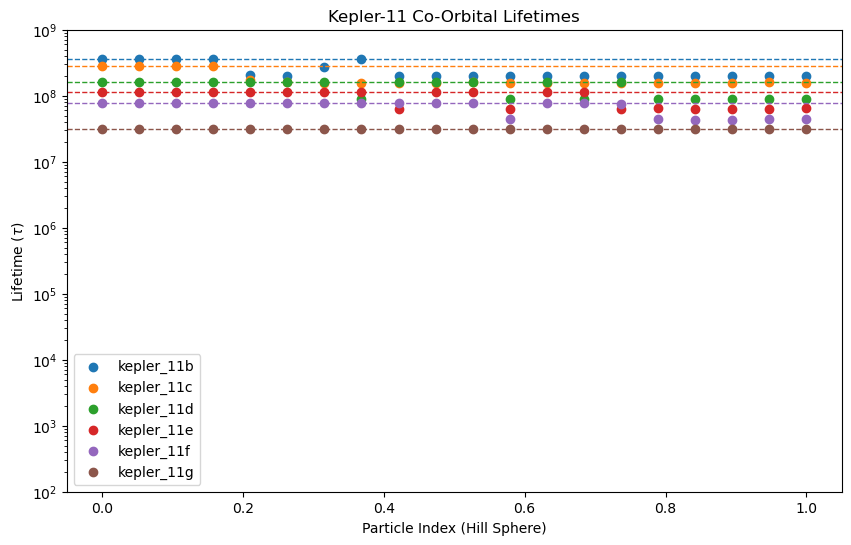

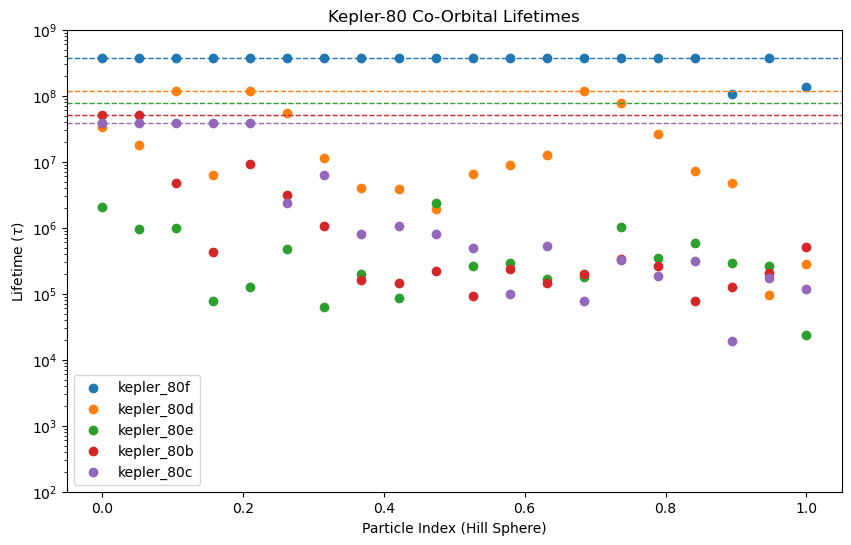

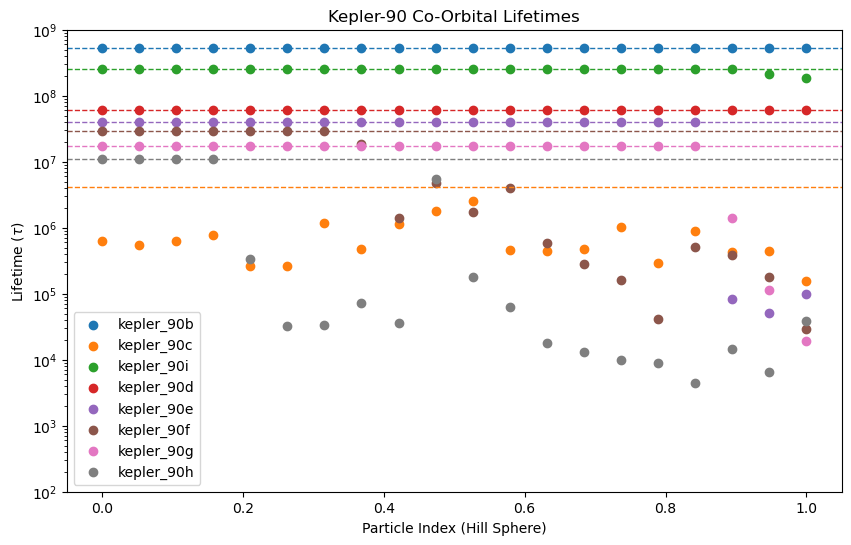

/Users/mariahjones/anaconda3/lib/python3.11/site-packages/rebound/simulationarchive.py:95: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/mariahjones/anaconda3/lib/python3.11/site-packages/rebound/simulationarchive.py:142: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)


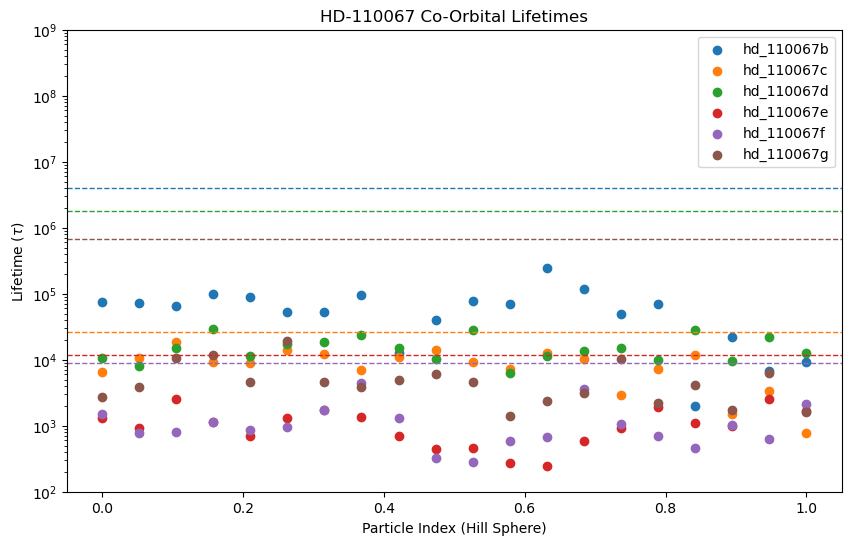

In [3]:
# Filenames
systems = {
    "TRAPPIST-1": ["trappist_1b.bin", "trappist_1c.bin", "trappist_1d.bin", "trappist_1e.bin", "trappist_1f.bin", "trappist_1g.bin", "trappist_1h.bin"],
    "Kepler-11": ["kepler_11b.bin", "kepler_11c.bin", "kepler_11d.bin", "kepler_11e.bin", "kepler_11f.bin", "kepler_11g.bin"],
    "Kepler-80": ["kepler_80f.bin", "kepler_80d.bin", "kepler_80e.bin", "kepler_80b.bin", "kepler_80c.bin"],
    "Kepler-90": ["kepler_90b.bin", "kepler_90c.bin", "kepler_90i.bin", "kepler_90d.bin", "kepler_90e.bin", "kepler_90f.bin", "kepler_90g.bin", "kepler_90h.bin"],
    "HD-110067": ["hd_110067b.bin", "hd_110067c.bin", "hd_110067d.bin", "hd_110067e.bin", "hd_110067f.bin", "hd_110067g.bin"]
}

colors = plt.cm.tab10(range(10))

for system_name, filenames in systems.items():
    plt.figure(figsize=(10, 6))  # new figure for each system

    for index, filename in enumerate(filenames):
        sa = rebound.Simulationarchive(path + filename)

        tmax = sa.tmax
        tmin = sa.tmin
        nshots = len(sa)
        times = np.linspace(tmin, tmax, nshots)

        # initialize lists
        fractional_indices = []
        normalized_stability_times = []

        # load first snapshot to get initial properties
        sim = sa[0]
        star_mass = sim.particles[0].m
        N_active = sim.N_active
        N_total = sim.N
        
        # determine the color for this planet
        color = colors[index % len(colors)]

        # special handling for Kepler-90
        if system_name == "Kepler-90":
            if "kepler_90b" in filename:
                planet_index = 1
                coorbital_start_index = 2
            elif "kepler_90c" in filename:
                planet_index = 2
                coorbital_start_index = 3
            elif "kepler_90i" in filename:
                planet_index = 3
                coorbital_start_index = 4
            elif "kepler_90d" in filename:
                planet_index = 4
                coorbital_start_index = 5
            elif "kepler_90e" in filename:
                planet_index = 5
                coorbital_start_index = 6
            elif "kepler_90f" in filename:
                planet_index = 6
                coorbital_start_index = 7
            elif "kepler_90g" in filename:
                planet_index = 7
                coorbital_start_index = 8
            elif "kepler_90h" in filename:
                planet_index = 8
                coorbital_start_index = 9

            planet = sim.particles[planet_index]
            a_planet = planet.a

            # Calculate Hill radius in AU
            hill_radius = (planet.m / (3 * star_mass))**(1/3)
            stability_threshold = 5 * hill_radius

            # Calculate the orbital period of the host planet
            planet_period = 2 * np.pi * np.sqrt(a_planet**3 / (star_mass))

            # Track stability times for each coorbital
            for j in range(coorbital_start_index, coorbital_start_index + 20):
                coorbital = sim.particles[j]

                # Compute the fractional index for the particle
                fractional_index = (j - coorbital_start_index) / 19

                # Track stability times
                stability_detected = False
                for k in range(nshots):
                    sim = sa[k]
                    planet_longitude = sim.particles[planet_index].l
                    coorbital_longitude = sim.particles[j].l

                    # Compute the difference as coorbital minus planet
                    difference = abs(coorbital_longitude - planet_longitude)
                    difference = min(difference, 2*np.pi - difference)  # Account for periodicity

                    # Check if the difference is below the stability threshold
                    if difference < stability_threshold:
                        stability_time = times[k]
                        normalized_tau = stability_time / planet_period
                        fractional_indices.append(fractional_index)
                        normalized_stability_times.append(normalized_tau)
                        stability_detected = True
                        break  # Stop if instability is detected

                if not stability_detected:
                    # If no instability is detected, assume stability till the end
                    normalized_tau = tmax / planet_period
                    fractional_indices.append(fractional_index)
                    normalized_stability_times.append(normalized_tau)

        else:
            # determine planet of interest based on index
            planet = sim.particles[index + 1]
            a_planet = planet.a

            # Hill radius (AU)
            hill_radius = (planet.m / (3 * star_mass))**(1/3)
            stability_threshold = 5 * hill_radius

            # orbital period of host planet
            planet_period = 2 * np.pi * np.sqrt(a_planet**3 / (star_mass))

            # track stability times for each coorbital
            for j in range(N_active, N_total):
                coorbital = sim.particles[j]

                # fractional index
                fractional_index = (j - N_active) / (N_total - N_active - 1)

                # track stability times
                stability_detected = False
                for k in range(nshots):
                    sim = sa[k]
                    planet_longitude = sim.particles[index + 1].l
                    coorbital_longitude = sim.particles[j].l

                    # difference in mean_lon
                    difference = abs(coorbital_longitude - planet_longitude)
                    difference = min(difference, 2*np.pi - difference)  # account for periodicity

                    # check stability threshold
                    if difference < stability_threshold:
                        stability_time = times[k]
                        normalized_tau = stability_time / planet_period
                        fractional_indices.append(fractional_index)
                        normalized_stability_times.append(normalized_tau)
                        stability_detected = True
                        break  # stop if instability is detected

                if not stability_detected:
                    # assume stability till the end
                    normalized_tau = tmax / planet_period
                    fractional_indices.append(fractional_index)
                    normalized_stability_times.append(normalized_tau)

        # extract results for plotting
        if normalized_stability_times and fractional_indices:
            label = filename.replace('.bin', '')
            plt.scatter(fractional_indices, normalized_stability_times, label=label, color=color)

            # Plot the instability threshold line
            threshold_tau = tmax / planet_period
            plt.axhline(y=threshold_tau, color=color, linestyle='--', linewidth=1)

    plt.xlabel('Particle Index (Hill Sphere)')  
    plt.ylabel(r'Lifetime ($\tau$)')  
    plt.ylim(10**2, 10**9)
    plt.title(f'{system_name} Co-Orbital Lifetimes')  
    plt.yscale('log')  
    #plt.grid(True)
    plt.legend()
    #plt.savefig(f'{system_name}_lifetime_indicators.png')
    plt.show()